In [1]:
%matplotlib notebook

import argparse
import sys
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=4)

import gym
from gym import wrappers, logger
# from gridworld_env import gridworld
from multigoal_env.multigoal import MultiGoal

from spinup.utils.mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs
from agents import RandomAgent

import torch
import tree

In [2]:
env_id = 'MultiGoal-v0'
seed = 1234

In [4]:
alpha = 0.01
gamma = 0.9
num_episodes = 20

In [5]:
def process_sample(observation, action,reward, 
                    terminal,next_observation,info):
    
    processed_observation = {
        'observations': observation,
        'actions': action,
        'rewards': np.atleast_1d(reward),
        'terminals': np.atleast_1d(terminal),
        'next_observations': next_observation,
        'infos': info,
    }

    return processed_observation

In [6]:
# fig, ax = init_plot()
# plot_position_cost(env, ax)
# plt.show()
# ! pip install dm-tree

In [16]:
env = gym.make(env_id)
env.seed(seed)
agent = RandomAgent(env.action_space)
reward = 0.
done = False

<IPython.core.display.Javascript object>


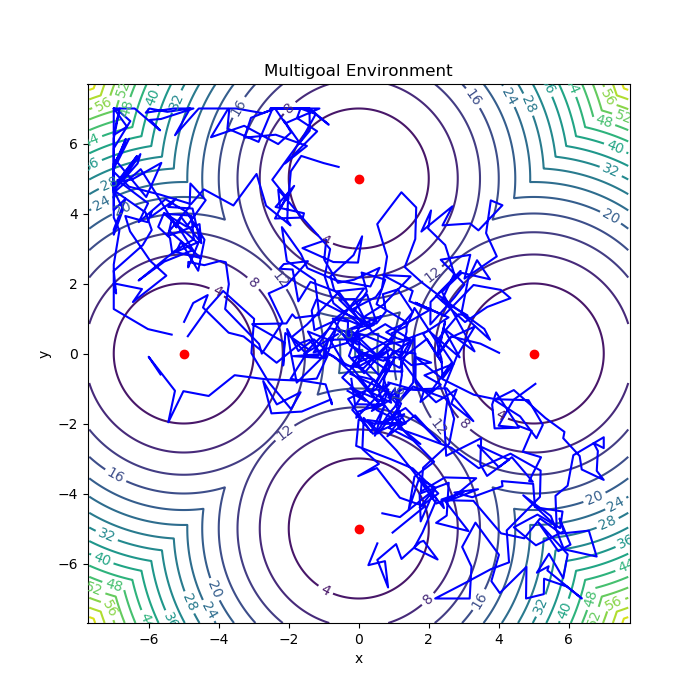

Episode Number: 5 | Total Reward: -2827.5185 
Episode Number: 10 | Total Reward: -3316.3528 


In [17]:
current_path = []
path_length = 0
path_return = 0.
num_episodes = 10
max_steps = 1000
all_paths = []

for episode in range(1, num_episodes+1):
    
    current_ob = env.reset()
    rewards = []
    
    while True:
        action = agent.act(current_ob, reward, done)
        ob, reward, done, info = env.step(action)

        processed_sample = process_sample(observation=current_ob, action=action, reward=reward,
                                          terminal=done, next_observation=ob,info=info)
        
        rewards.append(reward)
        current_path.append(processed_sample)
        
        path_length += 1

        if done or path_length > max_steps:
            current_ob = env.reset()
            path_length = 0
            last_path = tree.map_structure(lambda *x: np.stack(x, axis=0), *current_path)
            all_paths.append(last_path)
            env.render_rollouts(all_paths)
            current_path = []
            
            break
        else:
            current_ob = ob    
        
    if episode % 5 == 0:
        print ('Episode Number: {:d} | Total Reward: {:.4f} '.format(episode, np.sum(rewards)))

env.close()